In [ ]:
""""
Analyzes Seattle Airbnb data. Answers the following questions:
1)What is the proportion of listings in each neighbourhood? The distribution of property types?
    The distribution of room types?
2)What is the average rental price for an entire house in each neighbourhood? 
    What is the average cleaning fee per number of bedrooms?

3)What is the proportion of such houses  with each of the usual amenities?
4)What is a competitive price for an entire house rental?

""""

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from IPython import display
%matplotlib inline
from tkinter.filedialog import askopenfilename


In [2]:
#Allows user to browse for the data file
listings = askopenfilename()


In [3]:
#Reads the csv file
dflistings = pd.read_csv(listings)

In [4]:
#Load calendar file
calendar = askopenfilename()
dfcalendar = pd.read_csv(calendar)

In [5]:
dfcalendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
#Number of days covered by the data
len(set(dfcalendar.date))

365

In [7]:
#period  covered by the data
dfcalendar.date.sort_values()

0          2016-01-04
1171285    2016-01-04
442380     2016-01-04
997180     2016-01-04
1203040    2016-01-04
              ...    
924544     2017-01-02
924179     2017-01-02
923814     2017-01-02
928194     2017-01-02
1393569    2017-01-02
Name: date, Length: 1393570, dtype: object

In [8]:
#Data exploration
dflistings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [9]:
dflistings.shape

(3818, 92)

In [ ]:
#List the variables in the data
dflistings.columns

In [10]:
#Select the variables of interest
df = dflistings[['neighbourhood_group_cleansed','property_type', 'room_type', 'accommodates','bedrooms','bathrooms','beds','amenities','price','security_deposit','cleaning_fee']].copy()


In [11]:
#Look at variables with numeric values
df.select_dtypes(['int64','float']).head()

,accommodates,bedrooms,bathrooms,beds
0,4,1.0,1.0,1.0
1,4,1.0,1.0,1.0
2,11,5.0,4.5,7.0
3,3,0.0,1.0,2.0
4,6,3.0,2.0,3.0


In [12]:
#Look at variables with string values
df.select_dtypes(['object']).head()

,neighbourhood_group_cleansed,property_type,room_type,amenities,price,security_deposit,cleaning_fee
0,Queen Anne,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN
1,Queen Anne,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$100.00,$40.00
2,Queen Anne,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,"$1,000.00",$300.00
3,Queen Anne,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00,NaN,NaN
4,Queen Anne,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,$700.00,$125.00


In [13]:
#Remove dollar signs and commas in money and convert to the correct type
prices = ['price','security_deposit','cleaning_fee']
df[prices]=df[prices].replace(['\$',','],"",regex=True).astype(float)


In [14]:
def percentage(variable,title=""):
    """Calculates and plots the distribution of a qualitative variable.
    Args:
    variable (Panda Series)
    title (str): the title of the graph plot
    """
    proportion = variable.value_counts()
    print((proportion/len(df)).map("{:.2%}".format))
    proportion.plot(kind='bar',title = title);
    return proportion


Other neighborhoods    20.80%
Capitol Hill           14.85%
Downtown               13.88%
Central Area            9.66%
Queen Anne              7.73%
Ballard                 6.02%
West Seattle            5.32%
Rainier Valley          4.16%
University District     3.20%
Beacon Hill             3.09%
Cascade                 2.33%
Northgate               2.10%
Delridge                2.07%
Lake City               1.75%
Magnolia                1.60%
Seward Park             1.15%
Interbay                0.29%
Name: neighbourhood_group_cleansed, dtype: object


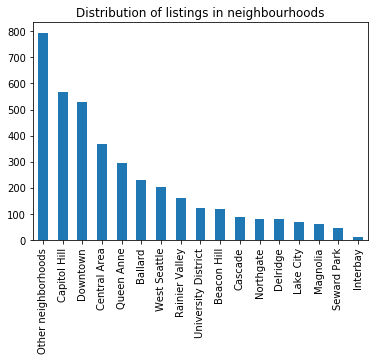

In [15]:
percentage(df.neighbourhood_group_cleansed,"Distribution of listings in neighbourhoods");

House              45.39%
Apartment          44.74%
Townhouse           3.09%
Condominium         2.38%
Loft                1.05%
Bed & Breakfast     0.97%
Other               0.58%
Cabin               0.55%
Bungalow            0.34%
Camper/RV           0.34%
Boat                0.21%
Tent                0.13%
Treehouse           0.08%
Chalet              0.05%
Dorm                0.05%
Yurt                0.03%
Name: property_type, dtype: object


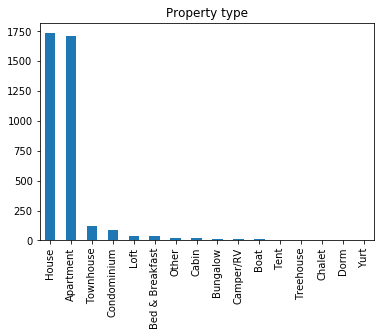

In [16]:
#Distribution of property types
percentage(df.property_type,'Property type');

Entire home/apt    66.55%
Private room       30.38%
Shared room         3.06%
Name: room_type, dtype: object


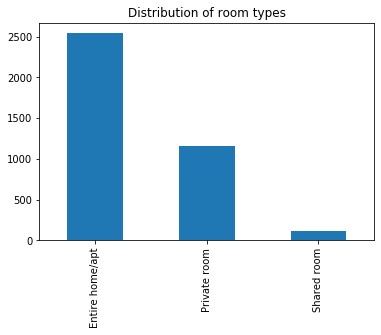

In [17]:
#Distribution of room types
percentage(df.room_type, 'Distribution of room types');

In [18]:
def averages(quant,qual,title=""):
    """
    Displays and plots averages of a quantitative variable for different levels of a categorical variable
    Args:
    quant (Pandas Series of floats)
    qual (Pandas Series)
    title (str): the title of the bar plot
    Returns:
        the_averages (Pandas Series of floats)
    """
    the_averages = quant.groupby(qual).mean().sort_values()
    print(the_averages)
    the_averages.plot(kind='bar',title=title)
    return the_averages


neighbourhood_group_cleansed
Delridge               101.461538
Northgate              125.888889
Rainier Valley         139.212766
Lake City              140.909091
Beacon Hill            143.607143
Interbay               150.000000
Seward Park            161.578947
Downtown               174.500000
Other neighborhoods    182.149425
Ballard                184.558140
West Seattle           190.857143
Central Area           191.250000
Cascade                199.428571
University District    220.363636
Magnolia               250.280000
Capitol Hill           259.955224
Queen Anne             272.716418
Name: price, dtype: float64


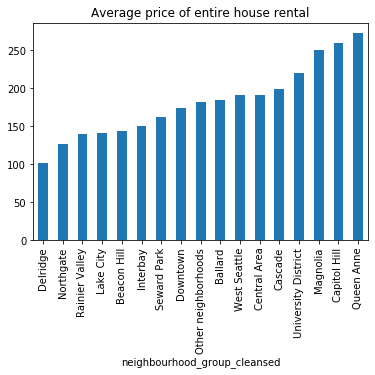

In [20]:
# Average rental price of entire house per neighbourhood
entire_houses = (df.property_type == 'House') & (df.room_type == 'Entire home/apt')
averages(df.price[entire_houses], df.neighbourhood_group_cleansed[entire_houses],title='Average price of entire house rental');


bedrooms
1.0     42.165012
0.0     45.177536
2.0     83.788043
3.0    119.543307
4.0    136.887097
5.0    211.904762
6.0    262.500000
7.0    300.000000
Name: cleaning_fee, dtype: float64


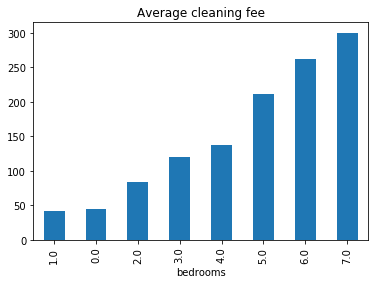

In [21]:
# Average cleaning fee per number of bedrooms
averages(df.cleaning_fee, df.bedrooms,title='Average cleaning fee');


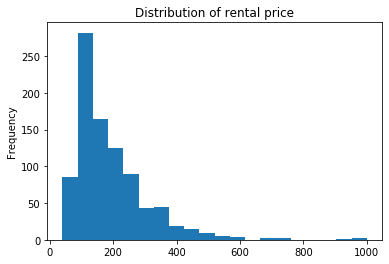

In [22]:
#Distribution of entire house rental price
df.price[entire_houses].plot(kind='hist',bins= 20, title= 'Distribution of rental price');

In [23]:

def occurrences(row, dic):
    """ extracts the options selected by an indivual from a string of the set of set options
    and increments the dictionary dic accordingly.
    Args:
        row (str): the set of options selected by an individual in a "select all that apply" type of 
                survey questions.
    Returns:
        dic (dictionary)
    
    """
    new_list = row.strip('{').strip('}').split(',')
    for element in new_list: 
        if element in dic:
            dic[element] += 1
        else:
            dic[element] = 1
    return dic

      

In [24]:
def options_and_counts(options) :
    """ Calculates the number of times each option is selected in a "check all that apply" type
    of questions.
    Args:
        options (Pandas Series)
    Returns:
        counts_dic (dictionary)
    """
    counts_dic = {}
    counts_dic = options.apply(func = occurrences, dic=counts_dic);
    return counts_dic.iloc[0]

      

In [25]:
    #Amenity availability for entire house rentals
    (pd.Series(options_and_counts(df.amenities[entire_houses]))/len(df.amenities[entire_houses])).sort_values(ascending=False).map("{:.2%}".format)


"Wireless Internet"             97.65%
Heating                         97.20%
Kitchen                         94.85%
"Smoke Detector"                89.37%
Essentials                      84.68%
Dryer                           82.33%
Washer                          82.21%
"Free Parking on Premises"      78.30%
Internet                        78.08%
TV                              77.63%
"Family/Kid Friendly"           74.38%
"Carbon Monoxide Detector"      70.47%
Shampoo                         69.69%
"Fire Extinguisher"             66.22%
"First Aid Kit"                 49.66%
"Cable TV"                      49.55%
"Indoor Fireplace"              37.58%
"Pets live on this property"    23.15%
"Safety Card"                   21.03%
Hangers                         20.92%
"Pets Allowed"                  20.36%
"Laptop Friendly Workspace"     20.25%
"Hair Dryer"                    19.35%
Iron                            19.02%
"24-Hour Check-in"              16.22%
"Air Conditioning"       

In [26]:
#The neighbourhood variable with too many levels (17) will generate too many dummy variables
#Instead use a new variable that gives the number of listings in a ward
df['neighbourhood_count']=df.neighbourhood_group_cleansed.value_counts()[df.neighbourhood_group_cleansed].reset_index(drop=True)


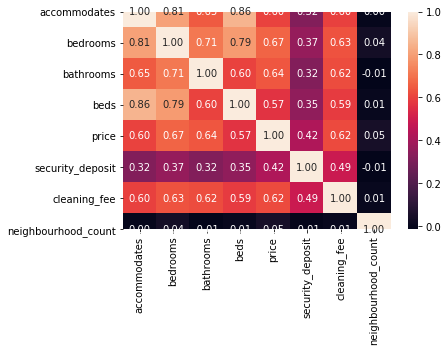

In [27]:
#Correlation matrix of the quantitative variables
sns.heatmap(df[entire_houses].corr(), annot=True,fmt='.2f');

In [28]:
#Negligible correlation of the new variable. Let us drop it
df.drop('neighbourhood_count',axis=1, inplace=True)

In [29]:
#Let us group the neighbourhoods according to average rental price of entire house
def assign_values(y):  
    """Creates a variable x conditional on the values of a variable y
    Args:
        y (Pandas Series)
    Returns:
        x (Pandas Series)
    """
    x=pd.Series(np.zeros(len(y)))
    x[y < 126] = 'cheapest'
    x[(y > 126) & (y < 161)] = 'cheaper'
    x[(y > 161) & (y < 199)] = 'average'
    x[(y > 199) & (y < 250)] = 'expensive'
    x[y > 250] = 'most_expensive'
    return(x)





neighbourhood_group_cleansed
Delridge               101.461538
Northgate              125.888889
Rainier Valley         139.212766
Lake City              140.909091
Beacon Hill            143.607143
Interbay               150.000000
Seward Park            161.578947
Downtown               174.500000
Other neighborhoods    182.149425
Ballard                184.558140
West Seattle           190.857143
Central Area           191.250000
Cascade                199.428571
University District    220.363636
Magnolia               250.280000
Capitol Hill           259.955224
Queen Anne             272.716418
Name: price, dtype: float64


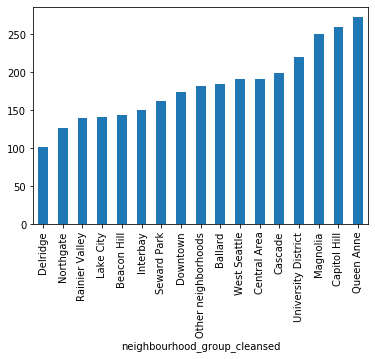

In [30]:
#Combining neighbourhoods into bigger areas
the_averages = averages(df.price[entire_houses], df.neighbourhood_group_cleansed[entire_houses]);
df['area']= assign_values(the_averages[df.neighbourhood_group_cleansed].reset_index(drop=True))

In [31]:
#drop the variable security_deposit and cleaning before regression model
df.drop(['neighbourhood_group_cleansed','amenities','security_deposit','cleaning_fee'],axis=1, inplace=True)

In [32]:
#Check missing values
df[entire_houses].isnull().sum()

property_type    0
room_type        0
accommodates     0
bedrooms         1
bathrooms        3
beds             0
price            0
area             0
dtype: int64

In [33]:
#Remove rows with missing values; there are very few of them
dflm= df[entire_houses].copy()
dflm.dropna(axis=0,inplace=True)

In [34]:
#Create dummy variables 
area_dummies = pd.get_dummies(dflm.area)
dflm = dflm.join(area_dummies)
dflm.drop('area',axis=1,inplace=True)

In [35]:
#Specify explanatory variables
X= dflm.drop(['property_type','room_type','price','most_expensive'],axis=1).copy()
y= dflm.price


In [36]:
# Split data for model validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state = 20)

In [37]:
#Regression model
def Regression_model(Xtrain, ytrain):
    #Fit linear regression model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(Xtrain,ytrain)
    
    print("Coefficients:")
    print(lm_model.coef_)
    
    print("Intercept:")
    print(lm_model.intercept_)
    
    #Coefficient of determination
    print("Coefficient of determination:")
    print(lm_model.score(Xtrain,ytrain))
    
    plt.scatter(x=ytrain, y=lm_model.predict(Xtrain));
    plt.title("Response vs Predicted")
    plt.xlabel(ytrain.name)
    plt.ylabel("Predicted")
    return lm_model;
    

Coefficients:
[ 0.02573266  0.20446372  0.16687414 -0.00553866 -0.17217746 -0.36883578
 -0.45223734 -0.05769083]
Intercept:
4.445244444602425
Coefficient of determination:
0.6215611936320644


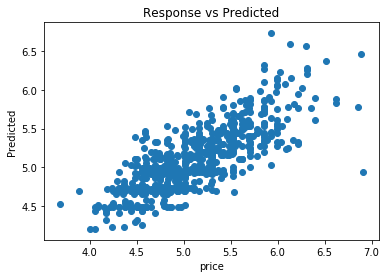

In [38]:
lm_model = Regression_model(Xtrain,  np.log(ytrain));

In [39]:
#Percentage absolute prediction error
(np.abs(np.exp(lm_model.predict(Xtest))-ytest)/ytest*100).describe()

count    223.000000
mean      27.898890
std       27.594824
min        0.501290
25%        9.169713
50%       22.587962
75%       36.224791
max      209.664911
Name: price, dtype: float64

In [40]:
#Residuals
res = np.exp(lm_model.predict(Xtrain))- ytrain

In [41]:
#Identify outliers
np.log(ytrain)[np.abs(res).sort_values(ascending=False).index[:2]]

3122    6.907755
3443    6.856462
Name: price, dtype: float64

In [42]:
#Remove outliers from training data
new_ytrain = ytrain.drop(np.abs(res).sort_values(ascending=False).index[:2],axis=0,inplace=False).copy()
new_Xtrain = Xtrain.drop(np.abs(res).sort_values(ascending=False).index[:2],axis=0,inplace=False).copy()

Coefficients:
[ 0.02552389  0.2005677   0.16323854 -0.16833399 -0.36048285 -0.44458295
 -0.05162904]
Intercept:
4.43719298526878
Coefficient of determination:
0.636118565182518


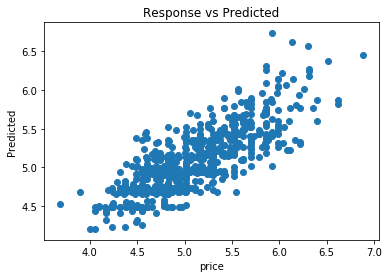

In [43]:
#Refit linear regression model with outliers and non-significant predictor removed
lm_model2 = Regression_model(new_Xtrain.drop('beds',axis=1,inplace=False), np.log(new_ytrain))


In [44]:
#Percentage absolute prediction error
(np.abs(np.exp(lm_model2.predict(Xtest.drop('beds',axis=1)))-ytest)/ytest*100).describe()

count    223.000000
mean      27.774478
std       27.298260
min        0.081771
25%        9.191360
50%       22.404544
75%       35.337330
max      208.879739
Name: price, dtype: float64